# 4. Adjoint optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Enoki library. Those are explained in the [Enoki documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Enoki records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse, convert_to_bitmap

def show_image(img, title):
    plt.imshow(convert_to_bitmap(img, crop_size)); plt.axis('off'); plt.title(title);

scene = load_file('../scenes/cbox.xml', res=128, spp=16, max_depth=3, integrator='rbp')
crop_size = scene.sensors()[0].film().crop_size()

params = traverse(scene)

# ek.set_flag(ek.JitFlag.VCallRecord, False)
# ek.set_flag(ek.JitFlag.LoopRecord, False)

2021-07-12 13:13:22 INFO main [xml.cpp:1242] Loading XML file "../scenes/cbox.xml" ..

2021-07-12 13:13:22 INFO main [xml.cpp:1243] Using variant "cuda_ad_rgb"

2021-07-12 13:13:22 INFO main [Scene] Building scene in OptiX ..

2021-07-12 13:13:22 INFO main [Scene] OptiX ready. (took 34ms)

2021-07-12 13:13:25 INFO main [SamplingIntegrator] Start rendering...

2021-07-12 13:13:25 INFO main [SamplingIntegrator] Computation graph recorded. (took 27ms)

2021-07-12 13:13:25 INFO main [SamplingIntegrator] Code generation finished. (took 496ms)

2021-07-12 13:13:25 INFO main [SamplingIntegrator] Rendering finished. (took 561ms)

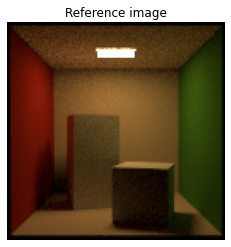

In [4]:
integrator = scene.integrator()
image_ref = integrator.render(scene, spp=128)
show_image(image_ref, 'Reference image')

2021-07-12 13:13:26 INFO main [SamplingIntegrator] Start rendering...

2021-07-12 13:13:26 INFO main [SamplingIntegrator] Computation graph recorded. (took 27ms)

2021-07-12 13:13:26 INFO main [SamplingIntegrator] Code generation finished. (took 5ms)

2021-07-12 13:13:26 INFO main [SamplingIntegrator] Rendering finished. (took 74ms)

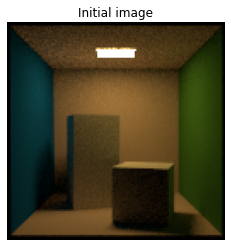

In [5]:
from mitsuba.core import Color3f, UInt32

# Update scene parameter
key = 'redwall.bsdf.reflectance.value'
params.keep([key])
param_ref = Color3f(params[key])
params[key] = Color3f(0.01, 0.2, 0.9)
params.update()

# Render initial image
scene.sensors()[0].sampler().seed(0)
image_init = integrator.render(scene, spp=128)
show_image(image_init, 'Initial image')

In [7]:
from mitsuba.python.ad import Adam

opt = Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [8]:
def compute_image_loss(image, obj_func):  
    ek.enable_grad(image)
    ob_val = obj_func(image)
    ek.backward(ob_val)
    image_loss = ek.grad(image)
    ek.set_grad(image, 0.0)
    return image_loss
    
def MSE(img):
    return ek.hsum_async(ek.sqr(img - image_ref)) / len(img)

from mitsuba.core import Thread, LogLevel
Thread.thread().logger().set_log_level(LogLevel.Error)

errors = []
for it in range(128):    
    scene.sensors()[0].sampler().seed(0)
    
#     img = mitsuba.python.ad.render(scene)
#     loss = ...
#     ek.backward(loss)
    
    # Perform a differentiable rendering of the scene
#     parameters.suspend_grad()
    image = integrator.render(scene, spp=16)
    image_adj = compute_image_loss(image, MSE)
    integrator.render_adjoint(scene, opt, image_adj, spp=16) # TODO pass opt?

    # Optimizer: take a gradient step
    opt.step()
    
    opt[key] = ek.clamp(opt[key], 0.0, 1.0)
    
    # Optimizer: Update the scene parameters
    opt.update()
        
    err_ref = ek.hsum(ek.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)

Iteration 000: error=0.921054
Iteration 001: error=0.819617
Iteration 002: error=0.739144
Iteration 003: error=0.671235
Iteration 004: error=0.612031
Iteration 005: error=0.557763
Iteration 006: error=0.508056
Iteration 007: error=0.461599
Iteration 008: error=0.418424
Iteration 009: error=0.377796
Iteration 010: error=0.339833
Iteration 011: error=0.304118
Iteration 012: error=0.270765
Iteration 013: error=0.239564
Iteration 014: error=0.210591
Iteration 015: error=0.183788
Iteration 016: error=0.159185
Iteration 017: error=0.136843
Iteration 018: error=0.116739
Iteration 019: error=0.0990351
Iteration 020: error=0.0836519
Iteration 021: error=0.0697224
Iteration 022: error=0.0566722
Iteration 023: error=0.0451499
Iteration 024: error=0.0345849
Iteration 025: error=0.0256323
Iteration 026: error=0.0177202
Iteration 027: error=0.0115088
Iteration 028: error=0.00641709
Iteration 029: error=0.00310109
Iteration 030: error=0.000944797
Iteration 031: error=0.000501631
Iteration 032: error=

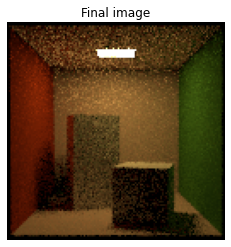

In [9]:
scene.sensors()[0].sampler().seed(0)
image_final = integrator.render(scene, spp=8)
show_image(image_final, 'Final image')

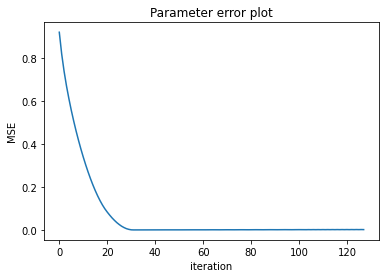

In [10]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Parameter error plot');

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)